https://www.kaggle.com/code/columbia2131/training-inference-code-xlm-roberta-base

### import

In [1]:
import numpy as np 
import pandas as pd 
import sys 
import os 
import logzero 
import wandb 
import pickle 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.utilities.seed import seed_everything


### config

In [2]:

class Config():
    # common
    version = '013'
    comment = 'roberta-base'
    input_dir = '/home/user/work/input/we-are-all-alike-on-the-inside'
    output_dir = f'/home/user/work/output/{version}' 
    seed = 42
    debug = False 
    target_col = None 

    # wandb
    wandb_init = {
        "project": "debug",
        "entity": "kuto5046",
        "group": f"exp{version}",
        "dir": output_dir,
        "tags": [],
        "resume": True,
        # "mode": "disabled", 
    }

    # cv 
    n_splits = 5
    use_fold = [0]  # fold1つで終える場合[0], 全てのfoldを実行する場合[0,1,2,3,4]

    # dataloader
    loader_params = {
        "train": {'batch_size': 32, 'shuffle': True, 'num_workers': 4},
        "valid": {'batch_size': 32, 'shuffle': False, 'num_workers': 4},
        "test": {'batch_size': 32, 'shuffle': False, 'num_workers': 4} 
        }

    # model
    # res
    resume_checkpoint_path = f"{output_dir}/model_fold0_epoch=6.ckpt"  # resume用
    # pretrained_model_path = f"{output_dir}/model_fold0_epoch=0.ckpt"  # 予測のみ用 
    n_epochs = 5
    model_name = 'xlm-roberta-base'
    max_len = 128
    weight_decay = 1e-3
    beta = (0.9, 0.98)
    lr = 3e-5
    num_warmup_steps_rate = 0
    gradient_accumulation_steps = 1  # 1なら累積しない

c = Config()
DEBUG = c.debug 
# c = HydraConfig.get_cnf(config_path='/home/user/work/configs/', config_name='config.yaml')
os.makedirs(c.output_dir, exist_ok=True)
logger = logzero.setup_logger(name='main', logfile=f'{c.output_dir}/result.log', level=10)

In [3]:
c.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
c.device

device(type='cuda')

In [4]:
from pytorch_lightning.utilities.seed import seed_everything
seed_everything(c.seed)

Global seed set to 42


42

### read data

In [5]:
train = pd.read_csv(f'{c.input_dir}/train.csv')
test = pd.read_csv(f'{c.input_dir}/test.csv')
train.shape, test.shape

((209573, 9), (139716, 8))

In [6]:
train.head()

,id,s1,s2,lang,lang_code,sim1,sim2,sim3,category
0,12c14e636472ca96a4d2278e0551d386,Un caméraman regarde une performance.,Un caméraman filmant une performance musicale.,French,fr,0.666667,0,0.0,association
1,952d00e2403b239e9c74270bc0a95221,"['Dos mujeres miran al espacio.', 'Ii charwoma...",Dos mujeres buscan en algún evento distante.,Spanish,es,0.288675,0,0.0,association
2,e10fc0fe22685baa17a93d63834f2773,There is a person in the snow.,A person playing sports in the snow is crouche...,English,en,0.597614,0,0.0,association
3,b137d6a58a985c4fef34a59df5dd5b82,"['Der Militär steht mit seiner Gitarre.', 'Der...",Ein Mann mit weißem Tanktop und Brille steuert...,German,de,0.094491,0,0.0,disagreement
4,cfb0eb8ff2d3f5dc191db41156e4acf1,"[""el pasajero de la moto de tierra está cruzan...",un ciclista de dirt bike cruza la roca.,Spanish,es,0.612372,0,0.0,unbiased


### preprocess

In [7]:
from src.features.base import get_categorical_col, get_numerical_col
from src.features.encoder import pp_for_categorical_encoding

In [8]:
whole = pd.concat([train, test]).reset_index(drop=True)

In [9]:
c.target_col = 'category'
c.n_class = 3
c.target_map = {'association': 0, 'disagreement': 1, 'unbiased': 2}
c.target_map_rev = {0: 'association', 1: 'disagreement', 2: 'unbiased'}

In [10]:
get_categorical_col(whole)

['id', 's1', 's2', 'lang', 'lang_code', 'category']

In [11]:
get_numerical_col(whole)

['sim1', 'sim2', 'sim3']

In [12]:
# import ast 
# def fix_s1s2(data):
#     new_s1 = []
#     new_s2 = []
#     for idx, row in tqdm(data.iterrows(), total=len(data)):
#         if row["s1"].startswith("["):
#             try:
#                 temp_s1 = " ".join(ast.literal_eval(row["s1"]))
#             except SyntaxError:
#                 temp_s1 = row["s1"][1:-1]
#         else:
#             temp_s1 = row["s1"]

#         if row["s2"].startswith("["):
#             try:
#                 temp_s2 = " ".join(ast.literal_eval(row["s2"]))
#             except SyntaxError:
#                 temp_s2 = row["s2"][1:-1]
#         else:
#             temp_s2 = row["s2"]

#         new_s1.append(temp_s1)
#         new_s2.append(temp_s2)
#     data["s1"] = new_s1
#     data["s2"] = new_s2
#     return data

In [ ]:
# whole = fix_s1s2(whole)

In [13]:
whole['s1'] = whole['s1'].map(
    lambda x: x\
        .replace("['", '')\
        .replace("']", '')\
        .replace('["', '')\
        .replace('"]', '')\
        .replace('[«', '«')
        .replace('»]', '»')\
        .replace('[', '')\
        .replace(']', '')\
        .split("', '")
)


whole['s1'] = whole['s1'].map(lambda x: ' '.join(x))

In [14]:
train = whole[~whole[c.target_col].isna()].reset_index(drop=True)
test = whole[whole[c.target_col].isna()].reset_index(drop=True)

In [15]:
# labelを数値に変換
train[c.target_col] = train[c.target_col].map(c.target_map)

### model

In [16]:
import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

2022-10-12 10:27:01.325463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 10:27:01.442095: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 10:27:01.794904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-12 10:27:01.794958: W te

In [17]:
class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, config: Config, phase: str='train'):
        assert phase in ['train', 'valid', 'test']
        self.config = config
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.phase = phase
        self.s1 = df['s1'].to_numpy()
        self.s2 = df['s2'].to_numpy()
        self.y = np.full(len(df), np.nan)
        if self.phase in ['train', 'valid']:
            self.y = df[config.target_col].to_numpy()
    
    def __len__(self):
        return self.s1.shape[0]

    def __getitem__(self, idx):
        # GET TEXT AND WORD LABELS 
        inputs1 = self.tokenizer.encode_plus(
            self.s1[idx],
            self.s2[idx],
            add_special_tokens=True,
            max_length=self.config.max_len, 
            padding='max_length',
            truncation=True, 
            # return_attention_mask=True,
        )
        
        x = {
            'token1': torch.tensor(inputs1['input_ids'], dtype=torch.long),
            'mask1': torch.tensor(inputs1['attention_mask'], dtype=torch.long),
        }
        return x, self.y[idx]

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import F1Score

class CustomModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()

        self.backbone = AutoModel.from_pretrained(config.model_name)
        ndim = 768
        self.ln = nn.LayerNorm(ndim)
        self.linear1 = nn.Sequential(
            nn.Linear(ndim, 256),
            nn.ReLU(),
            nn.Linear(256, config.n_class) 
        )
        self.dropout = nn.Dropout()

        self.criterion = self.get_criterion(config)
        self.optimizer = self.get_optimizer(config)
        self.scheduler = self.get_scheduler(config)
        self.metric = self.get_metric(config)
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(0.5)

    def forward(self, x):
        output = self.backbone(x['token1'], attention_mask=x['mask1'])["last_hidden_state"][:, 0, :]
        output = self.ln(output)
        logits1 = self.linear1(self.dropout1(output))   
        logits2 = self.linear1(self.dropout2(output))   
        logits3 = self.linear1(self.dropout3(output))   
        logits4 = self.linear1(self.dropout4(output))   
        logits5 = self.linear1(self.dropout5(output))   
        logits = (logits1 + logits2 + logits3 + logits4 + logits5) / 5
        logits = torch.softmax(logits, dim=-1)
        return output
    

    def _calculate_loss(self, batch, mode="train"):
        x, y = batch
        output = self(x)
        loss = self.criterion(output, y)
        score = self.metric(output, y) 

        self.log(f'Loss/{mode}', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Score/{mode}', score, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss 


    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")
    

    def validation_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="valid")


    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)


    def configure_optimizers(self):
        return {"optimizer": self.optimizer, "lr_scheduler": self.scheduler, "monitor": "Loss/valid"}


    def get_metric(self, config):
        return F1Score(average='micro')


    def get_optimizer(self, config: dict):

        param_optimizer = list(self.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']  # このパラメータはweight decayしない
        optimizer_grouped_parameters = [
                {
                    'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
                    'weight_decay': config.weight_decay
                },
                {
                    'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
                    'weight_decay': 0.0
                }
            ]

        optimizer = AdamW(
            optimizer_grouped_parameters,
            lr = config.lr,
            betas = config.beta,
            weight_decay = config.weight_decay,
            )
        return optimizer

    def get_scheduler(self, config: dict):
        num_train_optimization_steps = int(
            config.len_loader * config.n_epochs // config.gradient_accumulation_steps
        )
        num_warmup_steps = int(num_train_optimization_steps * config.num_warmup_steps_rate)
        
        scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_train_optimization_steps
        )
        return scheduler 


    def get_criterion(self, config: dict):
        criterion = nn.CrossEntropyLoss()
        return criterion

### cv

In [19]:
from src.cv import get_kfold, get_stratifiedkfold, get_groupkfold
cv = get_stratifiedkfold(train, c.target_col, n_splits=5)
cv

[(array([     0,      1,      2, ..., 209567, 209571, 209572]),
  array([     7,     11,     13, ..., 209568, 209569, 209570])),
 (array([     0,      1,      2, ..., 209569, 209570, 209572]),
  array([     9,     17,     22, ..., 209561, 209565, 209571])),
 (array([     0,      1,      3, ..., 209570, 209571, 209572]),
  array([     2,      5,      8, ..., 209545, 209564, 209566])),
 (array([     0,      1,      2, ..., 209570, 209571, 209572]),
  array([     3,      4,      6, ..., 209558, 209563, 209567])),
 (array([     2,      3,      4, ..., 209569, 209570, 209571]),
  array([     0,      1,     12, ..., 209549, 209562, 209572]))]

### train

In [20]:
from sklearn.metrics import f1_score, roc_auc_score
def calc_score(true, pred):
    return f1_score(true, pred.argmax(axis=1), average='micro')

In [21]:
def apply_device_to_dict(_dict, device):
    for k, v in _dict.items():
        _dict[k] = v.to(device)
    return _dict 
    
def to_np(input):
    return input.detach().cpu().numpy()

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

# def inference(model, loader, device):
#     model.eval()
#     model.to(device)
#     pred = []
#     with torch.no_grad():
#         # https://github.com/tqdm/tqdm/issues/746
#         for batch in tqdm(loader, total=len(loader)):
#             with torch.autocast(device_type=device.type):
#                 x, y = batch
#                 x = apply_device_to_dict(x, device)
#                 output = model(x)
#                 pred.append(to_np(output))
#     return np.concatenate(pred)

In [22]:
def train_pipeline(train, test, cv, config, target_col):
    for i, (idx_train, idx_valid) in enumerate(cv):
        if i not in c.use_fold:
            continue 

        wandb.init(**config.wandb_init, name=f'exp{config.version}-fold{i}', config=config)

        _train = train.loc[idx_train].reset_index(drop=True)
        _valid = train.loc[idx_valid].reset_index(drop=True)

        loaders = {}
        loaders["train"] = DataLoader(CustomDataset(_train, config, phase="train"), **config.loader_params['train'], worker_init_fn=worker_init_fn) 
        loaders["valid"] = DataLoader(CustomDataset(_valid, config, phase="valid"), **config.loader_params['valid'], worker_init_fn=worker_init_fn)
        loaders["test"] = DataLoader(CustomDataset(test, config, phase="test"), **config.loader_params['test'], worker_init_fn=worker_init_fn)
        c.len_loader = len(loaders['train'])



        # callback 
        checkpoint_callback = ModelCheckpoint(
            monitor=f'Score/valid',
            mode='max',
            dirpath=c.output_dir,
            filename=f'model_fold{i}_' + '{epoch}'  # pl内部のepochを読む
            )  

        early_stop_callback = EarlyStopping(
            monitor=f'Score/valid',
            mode='max'
            )

        trainer = pl.Trainer(
            logger=[WandbLogger()], 
            callbacks=[checkpoint_callback, early_stop_callback],
            max_epochs=c.n_epochs,
            devices='auto',
            accelerator='auto',
            fast_dev_run=DEBUG,
            deterministic=True,
            precision=16,
            )

        print('start train')
        model = CustomModel(c)
        trainer.fit(model, train_dataloaders=loaders['train'], val_dataloaders=loaders['valid'], ckpt_path=c.resume_checkpoint_path) # resumeする場合ここにcheckpointを渡す


        print('create oof')
        if not DEBUG:
            # best_checkpoint_path = f"{config.output_dir}/model_fold0_epoch=0.ckpt" # 
            best_checkpoint_path = checkpoint_callback.best_model_path
            logger.info(f'load best model {best_checkpoint_path}')
            model = model.load_from_checkpoint(checkpoint_path=best_checkpoint_path, config=config)
            config.best_checkpoint_path = best_checkpoint_path

        preds_valid = trainer.predict(model, loaders['valid'])
        pred_valid = to_np(torch.cat(preds_valid))
        oof = pd.DataFrame(pred_valid, index=idx_valid)
        oof.to_csv(f"{c.output_dir}/oof_{i}.csv", index=True) # もとの並びでconcatするときにindexが必要

        # evaluate
        print('evaluate valid data')
        score = calc_score(_valid[c.target_col], pred_valid)
        logger.info(f'fold-{i} score: {score}')
        wandb.log({'CV': score})

        # pred
        print('inference test data')
        preds_test = trainer.predict(model, loaders['test'])
        pred_test = to_np(torch.cat(preds_test))
        np.save(f"{c.output_dir}/pred_test_{i}", pred_test)

        # if i != c.use_fold[-1]:
        #     wandb.finish()

In [23]:
train_pipeline(train, test, cv, c, c.target_col)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


start train


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/user/work/output/012 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the che

Sanity Checking: 0it [00:00, ?it/s]

Training: 5240it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 221012 11:02:41 3718308697:52] load best model /home/user/work/output/012/model_fold0_epoch=7.ckpt


create oof


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 5240it [00:00, ?it/s]

[I 221012 11:03:36 3718308697:64] fold-0 score: 0.7747584396993916


evaluate valid data
inference test data


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 5240it [00:00, ?it/s]

### inference

In [24]:
preds = []
for i in range(len(cv)):
    if i not in c.use_fold:
        continue 
    # TODO 存在していればに変更
    pred = np.load(f'{c.output_dir}/pred_test_{i}.npy')
    preds.append(pred)
pred_test = np.mean(preds, axis=0).argmax(axis=1)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


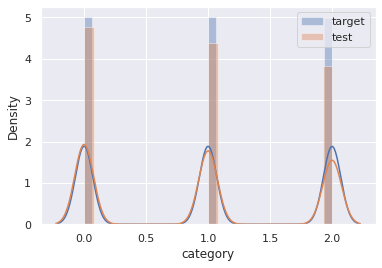

In [25]:
sns.distplot(train[c.target_col], label='target')
sns.distplot(pred_test, label='test')
plt.legend();

### submission

In [26]:
sub = pd.read_csv(f'{c.input_dir}/sample_submission.csv')
sub[c.target_col] = pred_test
sub.to_csv(f'{c.output_dir}/submission_exp{c.version}.csv', index=False)